# Long short-term memory

We saw that accounting for the temporal dependency helps to improve performance.
We found improvements with a hidden Markov model, but also using a simple
mode smoothing.
Here we look at using a more flexible model &mdash; the Long short-term
memory (LSTM) &mdash; to model the temporal dependency and smooth the predictions of
a random forest.

## Setup

In [24]:
import os
import json
import numpy as np
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

import utils  # helper functions -- check out utils.py

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))


Using cuda device: 0


In [25]:

DATASET_PATH = 'dataset/'  # path to your extracted windows
X_FEATS_PATH = 'X_feats.pkl'  # path to your extracted features
print(f'Content of {DATASET_PATH}')
print(os.listdir(DATASET_PATH))

with open(DATASET_PATH+'info.json', 'r') as f:
    info = json.load(f)  # load metadata

Y = np.memmap(DATASET_PATH+'Y.dat', mode='r', dtype=info['Y_dtype'], shape=tuple(info['Y_shape']))
T = np.memmap(DATASET_PATH+'T.dat', mode='r', dtype=info['T_dtype'], shape=tuple(info['T_shape']))
P = np.memmap(DATASET_PATH+'P.dat', mode='r', dtype=info['P_dtype'], shape=tuple(info['P_shape']))
X_feats = pd.read_pickle('X_feats.pkl')

labels = np.unique(Y)
num_labels = len(labels)

Y = np.where(Y.reshape(-1,1)==labels)[1]  # to numeric

print('Y shape:', Y.shape)
print('T shape:', T.shape)
print('P shape:', P.shape)
print('X_feats shape:', X_feats.shape)


Content of dataset/
['Y.dat', 'info.json', 'P.dat', 'T.dat', 'X.dat']
Y shape: (294309,)
T shape: (294309,)
P shape: (294309,)
X_feats shape: (294309, 22)


## Train/test split

In [26]:

# Take out 10 participants
test_ids = ['002', '003', '004', '005', '006', 
            '007', '008', '009', '010', '011']
mask_test = np.isin(P, test_ids)
mask_train = ~mask_test
X_train, Y_train, P_train, T_train = \
    X_feats[mask_train], Y[mask_train], P[mask_train], T[mask_train]
X_test, Y_test, P_test, T_test = \
    X_feats[mask_test], Y[mask_test], P[mask_test], T[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (274462, 22)
Shape of X_test: (19847, 22)


## Train a random forest classifier

*Note: this may take a while*

In [27]:
clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf.fit(X_train, Y_train)

Y_test_pred = clf.predict(X_test)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred, zero_division=0)) 

# This will be the training set
Y_in_train = clf.oob_decision_function_.astype('float32')
# This will be the test set
Y_in_test = clf.predict_proba(X_test).astype('float32')


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   55.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 2000 


## Architecture design
As a baseline, let's use a single-layer bidirectional LSTM.
PyTorch uses a sligtly unintuitive array format for the input and output of
its LSTM module.
The input and output shape is `(seq_length,N,num_labels)`, corresponding to 
`N` sequences of `seq_length` elements of size `num_labels`. 
Here, each element is a vector of label probabilities/logits.

In [28]:
class LSTM(nn.Module):
    ''' Single-layer bidirectional LSTM '''
    def __init__(self, input_size=5, output_size=5, hidden_size=1024):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.hidden2output = nn.Linear(2*hidden_size, output_size)

    def forward(self, sequence):
        hiddens, (hidden_last, cell_last) = self.lstm(
            sequence.view(len(sequence), -1, self.input_size))
        output = self.hidden2output(
            hiddens.view(-1, hiddens.shape[-1])).view(
                hiddens.shape[0], hiddens.shape[1], self.output_size
        )
        return output


## Helper functions

In [29]:
def create_dataloader(Y, y=None, seq_length=5, batch_size=1, shuffle=False, eval_mode=False):
    ''' Create a (batch) iterator over the dataset. It yields (batches of)
    sequences of consecutive rows of `Y` and `y` of length `seq_length` (can
    be less than `seq_length` in `eval_mode=True`). This iterator can also be
    implemented with PyTorch's Dataset and DataLoader classes -- See
    https://pytorch.org/tutorials/beginner/data_loading_tutorial.html '''
    if eval_mode:
        # In order to reuse this loader in evaluation/prediction mode, we
        # provide non-overlapping segments, as well as the trailing segments
        # that can be shorter than seq_length.
        n = len(Y)
        idxs = np.arange(0, n, seq_length)
    else:
        n = len(Y) - seq_length + 1
        idxs = np.arange(n)
    if shuffle:
        idxs = np.random.permutation(idxs)
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        # Separate those with irregular length -- these will be yielded one by one
        idxs_batch_regular = np.asarray(
            [j for j in idxs_batch if len(Y[j:j+seq_length]) == seq_length]
        )
        idxs_batch_irregular = np.asarray(
            [j for j in idxs_batch if j not in idxs_batch_regular]
        )
        # Yield batch of sequences of regular length (=seq_length)
        sequence_batch = np.stack([Y[j:j+seq_length] for j in idxs_batch_regular], axis=1)
        sequence_batch = torch.from_numpy(sequence_batch)
        if y is None:
            yield sequence_batch
        else:
            y_batch = np.stack([y[j:j+seq_length] for j in idxs_batch_regular], axis=1)
            y_batch = torch.from_numpy(y_batch)
            yield sequence_batch, y_batch
        # Yield sequences of irregular length uno por uno
        for j in idxs_batch_irregular:
            sequence_batch = torch.from_numpy(Y[j:j+seq_length]).unsqueeze(1)
            if y is None:
                yield sequence_batch
            else:
                y_batch = torch.from_numpy(y[j:j+seq_length]).unsqueeze(1)
                yield sequence_batch, y_batch


def forward_by_batches(lstm, Y_in, seq_length):
    ''' Forward pass model on a dataset. Do this by batches so that we do
    not blow up the memory. '''
    Y_out = []
    lstm.eval()
    with torch.no_grad():
        for sequence in create_dataloader(
            Y_in, seq_length=seq_length, batch_size=1024, shuffle=False, eval_mode=True
        ):  # do not shuffle here!
            sequence = sequence.to(device)
            output = lstm(sequence)
            Y_out.append(output)
    lstm.train()
    # Concatenate sequences in order -- need to transpose to get batch-first format
    Y_out = torch.cat(
        [output.transpose(1,0).reshape(-1, output.shape[-1]) for output in Y_out]
    )
    return Y_out


def evaluate_model(lstm, Y_in, Y, seq_length):
    Y_pred_prob = forward_by_batches(lstm, Y_in, seq_length)  # lstm smoothing (scores)
    loss = F.cross_entropy(Y_pred_prob, torch.from_numpy(Y).to(device)).item()

    Y_pred_prob = F.softmax(Y_pred_prob, dim=-1)  # convert to probabilities
    Y_pred = torch.argmax(Y_pred_prob, dim=-1)  # convert to classes
    Y_pred = Y_pred.cpu().numpy()  # cast to numpy array
    kappa = metrics.cohen_kappa_score(Y, Y_pred)

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}


 ## Hyperparameters, model instantiation, loss function and optimizer 

In [30]:
hidden_size = 128  # size of LSTM's hidden state
input_size = output_size = num_labels
seq_length = 5
num_epoch = 4
lr = 1e-4
batch_size = 32  # size of the mini-batch in SGD

lstm = LSTM(
    input_size=input_size,
    output_size=output_size,
    hidden_size=hidden_size
).to(device)
print(lstm)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=lr, amsgrad=True)


LSTM(
  (lstm): LSTM(6, 128, bidirectional=True)
  (hidden2output): Linear(in_features=256, out_features=6, bias=True)
)


 ## Training 

In [31]:
kappa_history = []
loss_history = []
loss_history_train = []
for i in tqdm(range(num_epoch)):
    dataloader = create_dataloader(Y_in_train, Y_train, seq_length, batch_size, shuffle=True)
    losses = []
    for sequence, target in dataloader:
        sequence, target = sequence.to(device), target.to(device)
        lstm.zero_grad()
        output = lstm(sequence)
        loss = loss_fn(output.view(-1,output.shape[-1]), target.view(-1))
        loss.backward()
        optimizer.step()

        # Logging -- track train loss
        losses.append(loss.item())

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch 
    # --------------------------------------------------------

    # Logging -- average train loss in this epoch
    loss_history_train.append(np.mean(losses))

    # Logging -- evaluate performance on test set
    results = evaluate_model(lstm, Y_in_test, Y_test, seq_length) 
    loss_history.append(results['loss'])
    kappa_history.append(results['kappa'])


 ## Model performane 


Classifier performance
Out of sample:
               precision    recall  f1-score   support

   bicycling       0.90      0.82      0.86       347
       mixed       0.57      0.62      0.59      1955
   sit-stand       0.90      0.91      0.90      8523
       sleep       0.96      0.97      0.97      7500
     vehicle       0.70      0.55      0.61       609
     walking       0.37      0.34      0.36       913

    accuracy                           0.86     19847
   macro avg       0.74      0.70      0.72     19847
weighted avg       0.86      0.86      0.86     19847



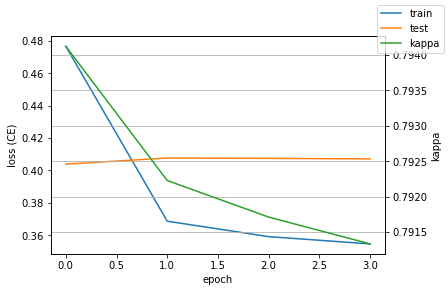

In [32]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train')
ax.plot(loss_history, color='C1', label='test')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()
fig.show()

# Report
Y_test_pred_lab = labels[results['Y_pred']]  # to labels
Y_test_lab = labels[Y_test]  # to labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test_lab, Y_test_pred_lab)) 
